---
# Adam Talbot Scratch - Forecasting
---

## Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

# time series imports
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# pickle for reloading model object
import pickle

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
# sns.set_palette('tab20')
plt.style.use('seaborn-darkgrid')

# custom modules
import wrangle as w
import explore as e

---
## Clustering

In [2]:
# load model
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

KMeans(n_clusters=7, random_state=527)

In [3]:
# acquire and prep data
df = w.get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = w.create_df_dict(df)
# charaterize series of data for each industry to make time series data into continuous data we can cluster on
char_df = e.create_char_df(industry_df_dict, ind_list)
# scale these characterizations for clustering
scaled_char_df = e.scale(char_df, MinMaxScaler())
# cluster and plot results
# char_df = e.load_cluster_and_plot_no_legend(loaded_model, scaled_char_df, char_df, df)

In [4]:
# char_df = e.load_cluster_and_plot_w_legend(loaded_model, scaled_char_df, char_df, df)

---
## Forecasting
---

#### Get dictionary of dfs for 12 industries we are interested in

In [5]:
def get_tx_data():
    '''
    Reads in raw data, filters, melts some columns to rows to get monthly observations, and creates datetime index
    '''
    df = pd.read_excel('QCEW-TX-L3-2016.xlsx') # get raw data
    # df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
    df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
    df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
    df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
    df['Date'] = df.apply(w.extract_date, axis=1) # use function to pull out date from multiple columns
    df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
    return df

In [6]:
def create_df_dict(df):
    '''
    Takes in df and creates a dictionary of series for all industries and the time interval we are interested in
    '''
    ind_list = df.Industry.value_counts().index.tolist() # get list of industries
    ind_list.remove('Monetary Authorities-Central Bank') # remove this industry since it has missing data
    ind_list.remove('Unclassified') # remove this industry since it is a catchall for a lot of unique industries that would be noise for our clustering
    industry_df_dict = {} # create empty df for dfs for each industry
    for ind in ind_list:
        industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index() # pull out series
    return industry_df_dict, ind_list

In [7]:
# get dictionary with all industries
# get all monthly data
df = get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = create_df_dict(df)

In [8]:
forecast_ind_list = [
    'Performing Arts, Spectator Sports, and Related Industries',
    'Miscellaneous Store Retailers ',
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ',
    'Accommodation',
    'Food Services and Drinking Places',
    'Motion Picture and Sound Recording Industries',
    'Personal and Laundry Services',
    'Furniture and Home Furnishings Stores ',
    'Leather and Allied Product Manufacturing',
    'Amusement, Gambling, and Recreation Industries',
    'Scenic and Sightseeing Transportation',
    'Clothing and Clothing Accessories Stores '
]

In [9]:
len(forecast_ind_list)

12

In [10]:
forecast_ind_dict = {}
for ind in forecast_ind_list:
    forecast_ind_dict[ind] = industry_df_dict[ind]

In [11]:
len(forecast_ind_dict)

12

In [12]:
forecast_ind_dict['Clothing and Clothing Accessories Stores ']

Date
2016-01-01    115461
2016-02-01    111574
2016-03-01    112055
2016-04-01    110324
2016-05-01    110453
               ...  
2021-02-01     84663
2021-03-01     86150
2021-04-01     88391
2021-05-01     93523
2021-06-01     95838
Name: Total Employment, Length: 66, dtype: int64

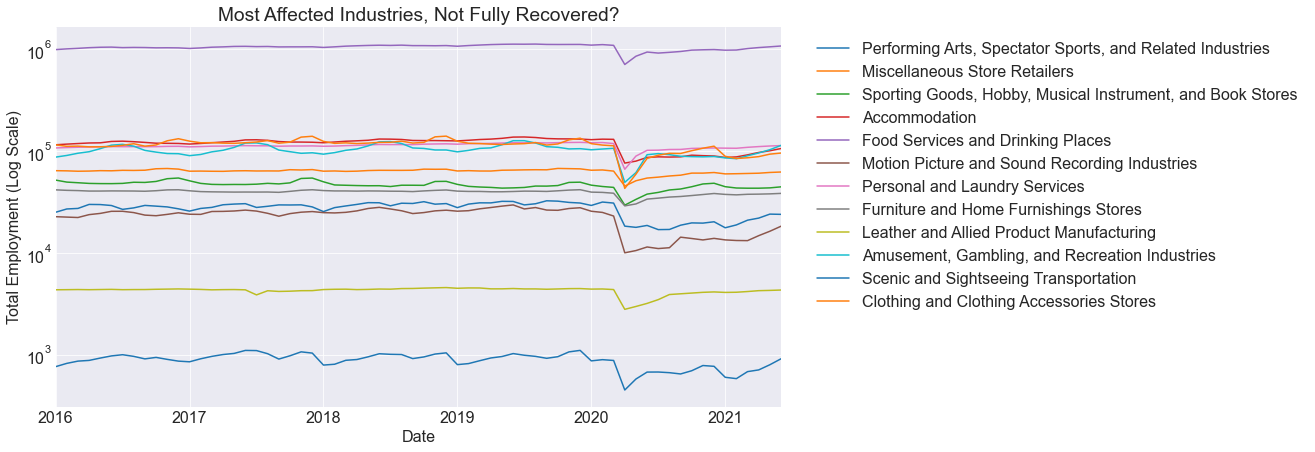

In [13]:
for ind in forecast_ind_list:
    forecast_ind_dict[ind].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Most Affected Industries, Not Fully Recovered?')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

In [14]:
# create a metric of (June 2021 / June 2019) * 100

In [15]:
def characterize_series(s):
    '''
    Takes in a series of times series data and characterizes it based on it's behavior over a specified interval
    '''
    recovery = (s['2021-06'][0] / s['2019-06'][0]) * 100
    characteristic_dict = {
        'recovery' : recovery
    }
    return characteristic_dict

In [16]:
def create_char_df(industry_df_dict):
    '''
    Creates a pandas df of characterstics of section of times series data
    '''
    characteristics = [] # create empty list for list of dictionaries
    ind_list = list(industry_df_dict.keys())
    for ind in ind_list: # loop through industries
        s = industry_df_dict[ind] # characterize them each using function
        characteristics.append(characterize_series(s)) # append to list of dicts
    char_df = pd.DataFrame(characteristics, index=ind_list) # convert to df
    return char_df

In [17]:
create_char_df(forecast_ind_dict).sort_values(by='recovery')

,recovery
Motion Picture and Sound Recording Industries,61.763515
"Performing Arts, Spectator Sports, and Related Industries",74.684926
Accommodation,77.209860
Clothing and Clothing Accessories Stores,81.494898
Scenic and Sightseeing Transportation,88.888889
"Amusement, Gambling, and Recreation Industries",89.903270
Personal and Laundry Services,93.778813
Miscellaneous Store Retailers,95.706924
Furniture and Home Furnishings Stores,95.801793
Food Services and Drinking Places,95.909662


---
### Resumption
---

####  Sporting Goods, Hobby, Musical Instrument, and Book Stores

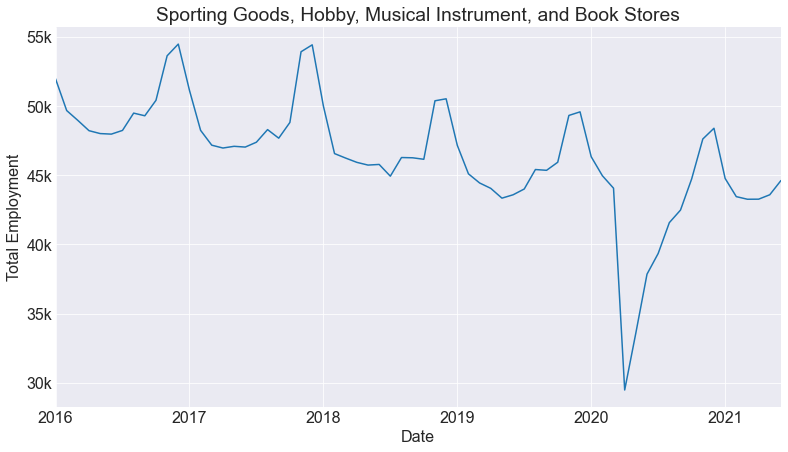

In [161]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_sporting = forecast_ind_dict['Sporting Goods, Hobby, Musical Instrument, and Book Stores ']
s_sporting.plot()
plt.gca().set(ylabel = 'Total Employment', title='Sporting Goods, Hobby, Musical Instrument, and Book Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [162]:
train = s_sporting['2016' : '2018']
# validate = s_sporting['2018']
test = s_sporting['2019']

In [163]:
# create a function to visualize splits
def viz_splits(train, validate, test):
    ax = train.plot(label='train')
    # validate.plot(ax=ax, label='validate')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

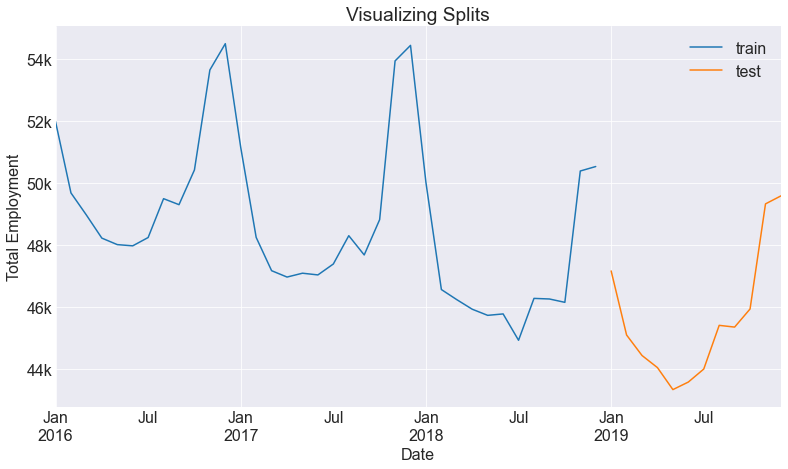

In [164]:
viz_splits(train, validate, test)

##### Seasonal Decomp 

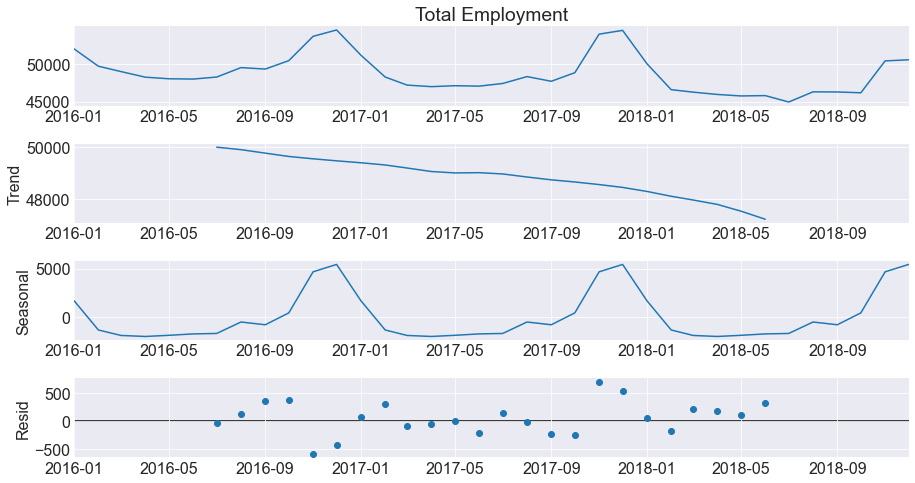

In [165]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast

In [166]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

In [167]:
train.diff(12).mean()

-1482.7916666666667

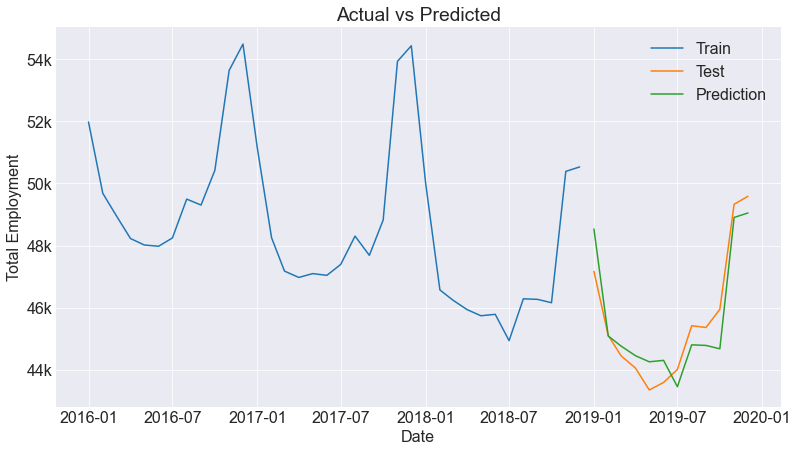

In [168]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [169]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

738.7250195532088

In [170]:
# get R^2
explained_variance_score(test, forecast)

0.8638711606813445

In [171]:
# predict the future
# want to predict 1.5 years into future to get us to end of year 2022
# get values for 1.5 years preceding pandemic 2018-07 to 2019-12
historical = s_sporting['2018-07' : '2019-12']

In [172]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

In [173]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

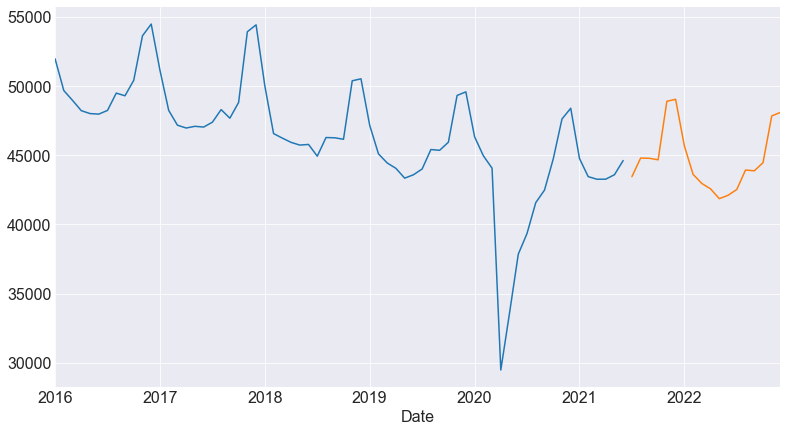

In [174]:
s_sporting.plot()
future.plot()

''

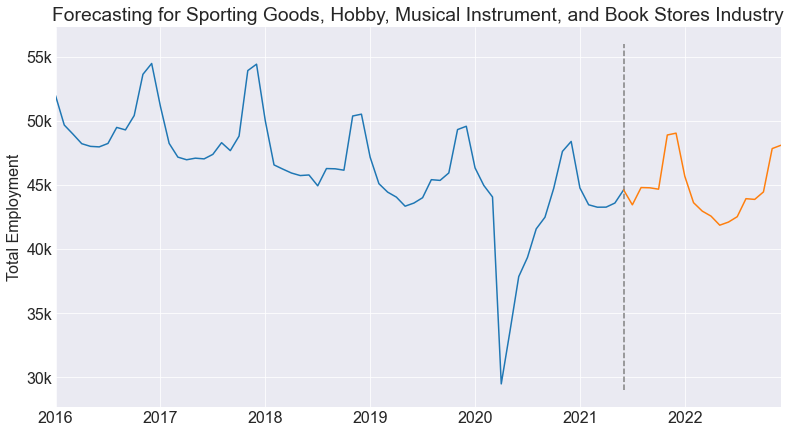

In [177]:
pd.concat([s_sporting, future])[: '2021-06'].plot()
pd.concat([s_sporting, future])['2021-06' : ].plot()
plt.vlines(x='2021-06', ymin=29_000, ymax=56_000, linestyles='--', colors='gray')
plt.gca().set(title='Forecasting for Sporting Goods, Hobby, Musical Instrument, and Book Stores Industry', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
;

---
### Recovery
---

####  Motion Picture and Sound Recording Industries

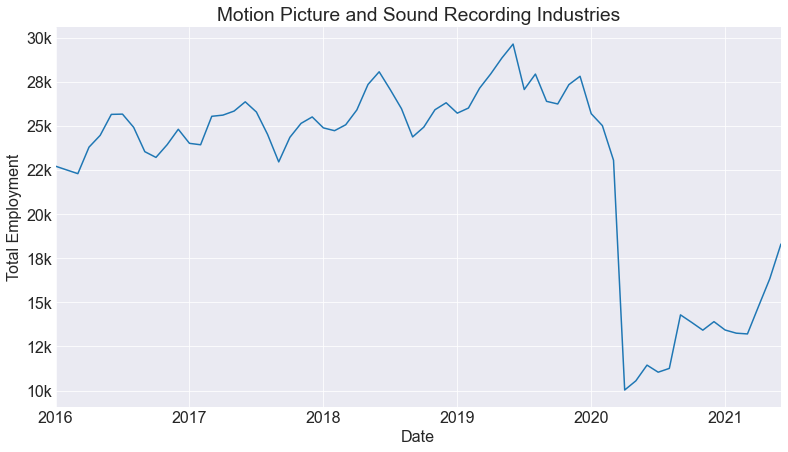

In [150]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_motion = forecast_ind_dict['Motion Picture and Sound Recording Industries']
s_motion.plot()
plt.gca().set(ylabel = 'Total Employment', title='Motion Picture and Sound Recording Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

<AxesSubplot:xlabel='Date'>

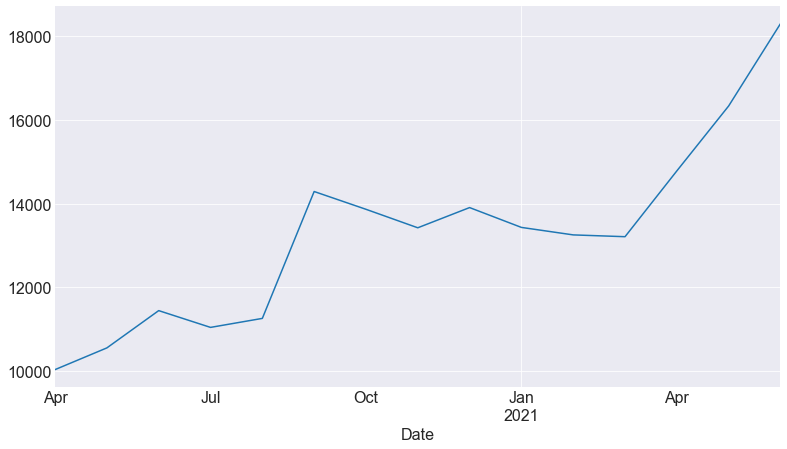

In [152]:
# zoom in on behavior since pandemic
s_motion['2020-04' : ].plot()